# Sentinel-2 unsupervised classification
## using Jupyter Notebook, SNAP and snapista

In [1]:
#importing libraries

import os
import sys
import time
from subprocess import Popen, PIPE, STDOUT
import glob
import shutil
from datetime import datetime
import numpy, matplotlib
#!pip install rasterio
try: 
    import rasterio
except:
    !pip install rasterio
from rasterio.plot import show

# snapista imports
from snapista import Graph
from snapista import Operator, OperatorParams

import sys
import os

In [2]:
from snapista import Graph
from snapista import Operator
from snapista import TargetBand
from snapista import TargetBandDescriptors

# You can get a list of operators by uncommented the line below
#Graph.list_operators()

### Unzipping S2 image

In [5]:
import zipfile
import glob
import os
datadir='/home/jovyan/data'
workdir='/home/jovyan/work'
myfile=glob.glob(os.path.join(datadir,'S2*zip'))


lonmin=31.617
latmin=30.366
lonmax=32.061
latmax=30.60
polygon='POLYGON (('+str(lonmin)+' '+str(latmin)+','+str(lonmin)+' '+str(latmax)+','+str(lonmax)+' '+str(latmax)+','+str(lonmax)+' '+str(latmin)+','+str(lonmin)+' '+str(latmin)+'))'

with zipfile.ZipFile(myfile[0], 'r') as zip_ref:
    zip_ref.extractall(workdir)

### Creating indices

In [6]:
def creating_indices(myfile,wktaoi):
    indices=['ndvi','mndwi','ndbi','bi']
    Bands2=['B8','B12','B12','B4']
    Bands1=['B4','B3','B8','B3']
    k=0
    if os.path.isfile('/home/jovyan/mytempgraph.xml'):
        os.remove("/home/jovyan/mytempgraph.xml")
    else: 
        print("The file was not created yet")
    outfile=['myndvi.tif','mymndwi.tif','myndbi.tif','mybi.tif']
    outputfile=[]
    for name in outfile:
        outputfile.append(os.path.join(os.getcwd(),'work',name))
    
    for index in indices:
        print('############################################################')
        print('############################################################')
        print('Creating normalised index: '+index+' called '+outputfile[k])
        b2=Bands2[k]
        b1=Bands1[k]
        normalised_index = TargetBand(name=index,
            expression='($1.'+b2+'-$2.'+b1+')/($1.'+b2+'+$2.'+b1+')')
            #expression='S9_BT_in < 265 ? 0 : F1_BT_in > 315 and (F1_BT_in - F2_BT_in) > 15 ? 1 : 0')
        band_maths = Operator('BandMaths')
        band_maths.targetBandDescriptors = TargetBandDescriptors([normalised_index])
        g=Graph()
        #Read
        g.add_node(
            operator=Operator(
                "Read",
                file=myfile,
            ),
            node_id="read",
        )
        # Band select 1
        g.add_node(
            operator=Operator(
                "BandSelect",
                sourceBandNames=b2,
            ),
            node_id='select1',
            source='read',
        )                              
        # Band Select 2
        g.add_node(
            operator=Operator(
                "BandSelect",
                sourceBandNames=b1,
            ),
            node_id='select2',
            source='read',
        )
        # Subset
        g.add_node(
            operator=Operator('Subset', geoRegion=wktaoi),
            node_id='subset2',
            source='select2',
        )
        if b2 == "B12":
                g.add_node(
                    operator=Operator(
                        'Resample',
                        targetResolution='10',
                     ),
                    node_id='resample',
                    source='select1',
                )
                # Subset
                g.add_node(
                    operator=Operator('Subset', geoRegion=wktaoi),
                    node_id='subset1',
                    source='resample',
                )
        else:
            # Subset
            g.add_node(
                operator=Operator('Subset', geoRegion=wktaoi),
                node_id='subset1',
                source='select1',
            )
            
        # Band Math
        g.add_node(operator=band_maths,
            node_id='bandMath',
            source=['subset1','subset2'],
        )
        
        # Write to GeoTIFF
        g.add_node(
            operator=Operator("Write", file=outputfile[k], formatName="GeoTIFF"),
            node_id="write",
            source='bandMath',
        )
        ##############################
        ## Executing graph
        ##############################
        print(g)
        #Uncomment the line below to save the graph to disc
        #g.save_graph('mytempgraph.xml')
        g.run()
        k=k+1
                    


## Launching the indices generation

In [7]:

lonmin=31.617
latmin=30.366
lonmax=32.061
latmax=30.60
polygon='POLYGON (('+str(lonmin)+' '+str(latmin)+','+str(lonmin)+' '+str(latmax)+','+str(lonmax)+' '+str(latmax)+','+str(lonmax)+' '+str(latmin)+','+str(lonmin)+' '+str(latmin)+'))'
myfile=glob.glob(os.path.join(datadir,'S2*zip'))[0]
print(myfile)

#file2process=glob.glob(os.path.join(workdir,os.path.basename(myfile)))[0][:-4]+'.SAFE/MTD_MSIL1C.xml'
file2process=os.path.join(workdir,os.path.basename(myfile))[:-4]+'.SAFE/MTD_MSIL2A.xml'

print(file2process)
creating_indices(file2process,polygon)


/home/jovyan/data/S2A_MSIL2A_20210602T082601_N0300_R021_T36RUU_20210602T131906.zip
/home/jovyan/work/S2A_MSIL2A_20210602T082601_N0300_R021_T36RUU_20210602T131906.SAFE/MTD_MSIL2A.xml
The file was not created yet
############################################################
############################################################
Creating normalised index: ndvi called /home/jovyan/work/myndvi.tif
gpt binary: /opt/conda/snap/bin/gpt
working dir: .

<graph>
  <version>1.0</version>
  <node id="read">
    <operator>Read</operator>
    <sources/>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <bandNames/>
      <copyMetadata>true</copyMetadata>
      <file>/home/jovyan/work/S2A_MSIL2A_20210602T082601_N0300_R021_T36RUU_20210602T131906.SAFE/MTD_MSIL2A.xml</file>
      <formatName/>
      <geometryRegion/>
      <maskNames/>
      <pixelRegion/>
    </parameters>
  </node>
  <node id="select1">
    <operator>BandSelect</operator>
    <sources>
      <sourceProduct refi

# Visualising normalised indices and histograms

/home/jovyan/work/mybi.tif


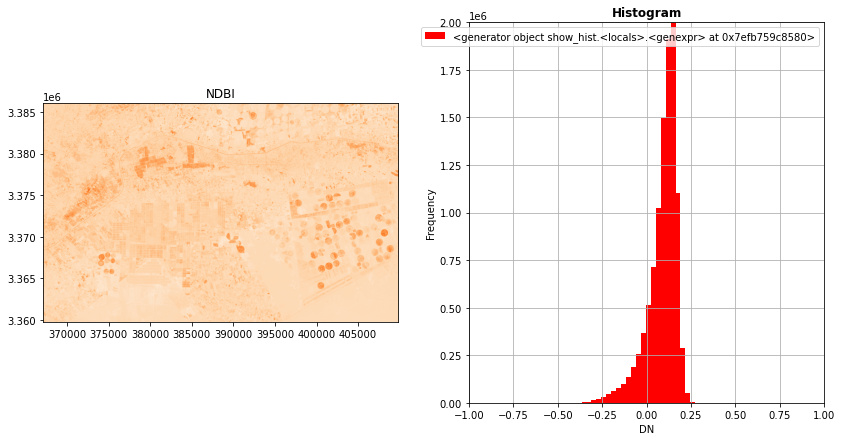

/home/jovyan/work/myndvi.tif


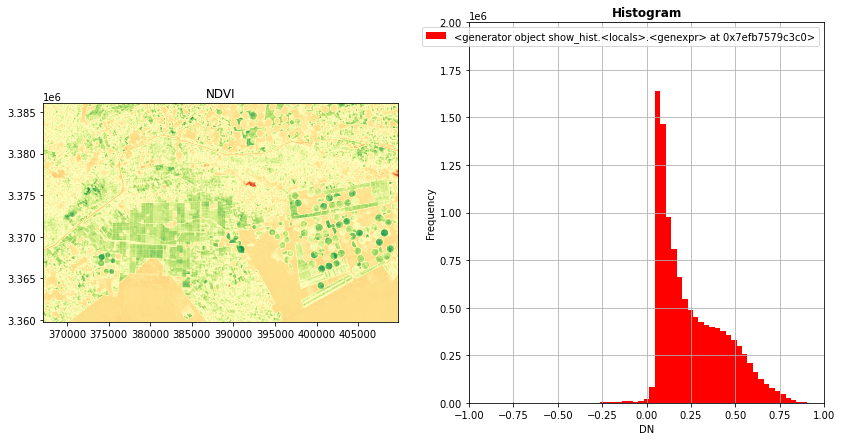

/home/jovyan/work/myndbi.tif


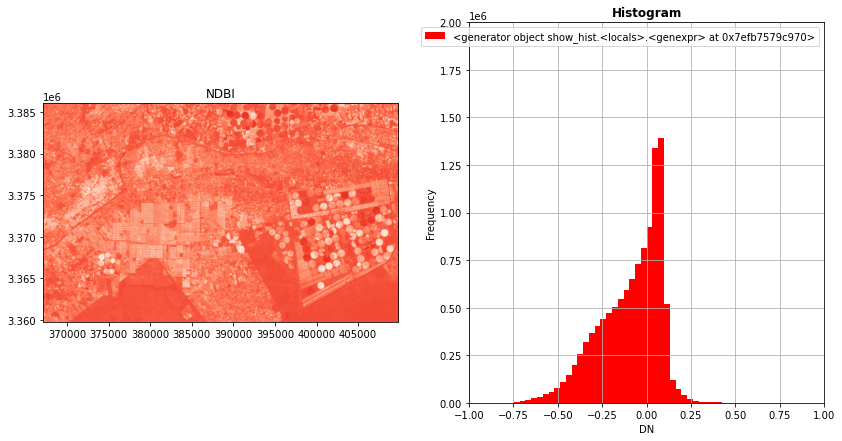

/home/jovyan/work/mymndwi.tif


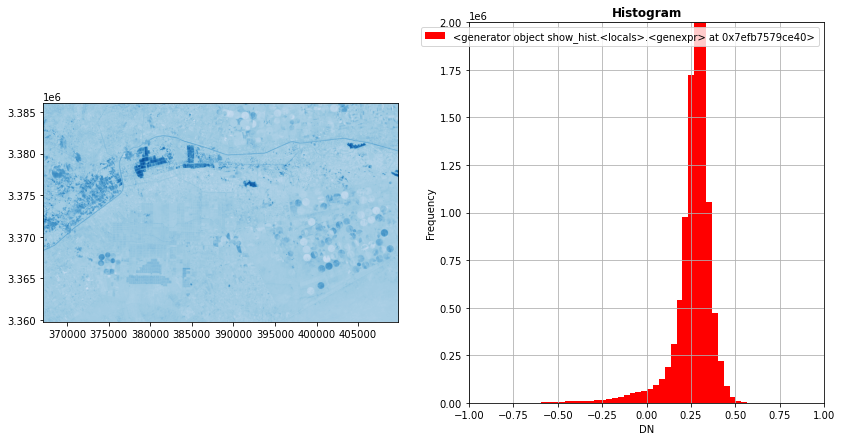

In [8]:
#!pip install rasterio
import rasterio
from rasterio.plot import show_hist, show
from matplotlib import pyplot
import numpy as np
import glob
import os

workdir='/home/jovyan/work'
cmaps=['Oranges_r','RdYlGn','Reds','Blues_r']
mytitle=['NDBI','NDVI','NDBI','']
k=0
for image in glob.glob(workdir+'/my*tif'):
    print(image)
    with rasterio.open(image) as src:
        band=src.read(1)
        #show_hist(band, bins=100, masked=True, title='Histogram', ax=None, label=None)
        #show(band,cmap='gray')
        fig, (axrgb, axhist) = pyplot.subplots(1, 2, figsize=(14,7))
        #fig.colorbar(band,ax=axrgb)
        axrgb.set_title(mytitle[k])
        show(src, ax=axrgb,cmap=cmaps[k])
        show_hist(src, bins=50, histtype='stepfilled',lw=0.0, stacked=False, ax=axhist)
        axhist.set(xlim=(-1, 1), ylim=(0, 2e6))
        pyplot.show()
        k=k+1

# Stacking and classifying the created indices

## Using rasterio for stacking of the normalised indices

In [9]:
# Using rasterio for stacking the indices
import rasterio

file_list=glob.glob('/home/jovyan/work/my*tif')

# Read metadata of first file
with rasterio.open(file_list[0]) as src0:
    meta = src0.meta

# Update meta to reflect the number of layers
meta.update(count = len(file_list))

# Read each layer and write it to stack
with rasterio.open(os.path.join(workdir,'S2_indices_stack.tif'), 'w', **meta) as dst:
    for id, layer in enumerate(file_list, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

# Classifying the indices using Unsupervised classification

In [5]:
def classifying(mystack):
    outputfile=os.path.join('/home/jovyan/work','classification.tif')
    
    ######################
    ### Creating Graph ###
    g = Graph()
    # Read
    g.add_node(
        operator=Operator(
            "Read",
            file=mystack,
        ),
        node_id="read",
    )
    # Unsupervised classifier
    g.add_node(
        operator=Operator(
            'EMClusterAnalysis',
            clusterCount='8',
            iterationCount='5',
            #sourceBandNames='band_1,band_2,band_3,band_4',
        ),
        node_id='classifier',
        source='read',
    )
    # Write to GeoTIFF-BigTIFF
    g.add_node(
        operator=Operator("Write", file=outputfile, formatName="GeoTIFF"),
        node_id="write",
        source='classifier',
    )

    ##############################
    ## Executing graph
    ##############################
    print(g)
    #Uncomment the line below to save the graph to disc
    g.save_graph('myclassif.xml')
    g.run()

In [6]:
stack2classify=glob.glob('/home/jovyan/work/S2_indices_stack.tif')[0]
print('Stack to classify')
print(stack2classify)
classifying(stack2classify)

Stack to classify
/home/jovyan/work/S2_indices_stack.tif
gpt binary: /opt/conda/snap/bin/gpt
working dir: .

<graph>
  <version>1.0</version>
  <node id="read">
    <operator>Read</operator>
    <sources/>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <bandNames/>
      <copyMetadata>true</copyMetadata>
      <file>/home/jovyan/work/S2_indices_stack.tif</file>
      <formatName/>
      <geometryRegion/>
      <maskNames/>
      <pixelRegion/>
    </parameters>
  </node>
  <node id="classifier">
    <operator>EMClusterAnalysis</operator>
    <sources>
      <sourceProduct refid="read"/>
    </sources>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <clusterCount>8</clusterCount>
      <includeProbabilityBands>false</includeProbabilityBands>
      <iterationCount>5</iterationCount>
      <randomSeed>31415</randomSeed>
      <roiMaskName/>
      <sourceBandNames/>
    </parameters>
  </node>
  <node id="write">
    <operator>Write</operator>
 

# Looking at histogram distribution of classes

/home/jovyan/work/classification.tif


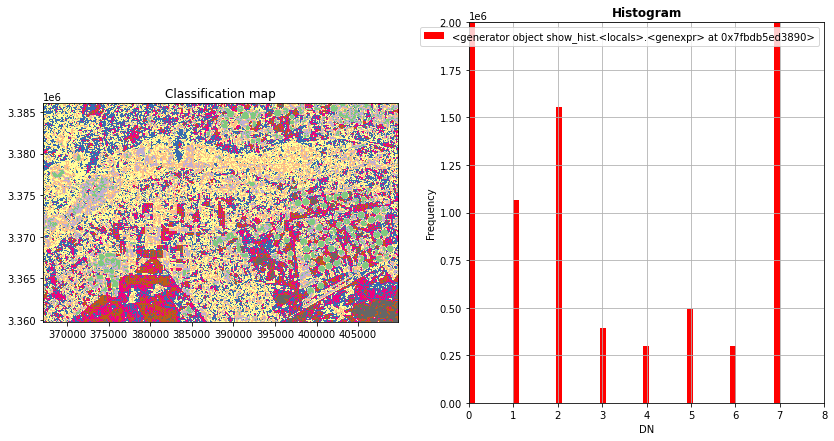

In [12]:
try:
    import rasterio
except:
    !pip install rasterio
    import rasterio
from rasterio.plot import show_hist, show
from matplotlib import pyplot
import numpy as np
import glob
import os

workdir='/home/jovyan/work'
for image in glob.glob(workdir+'/classif*tif'):
    print(image)
    with rasterio.open(image) as src:
        band=src.read(1)
        #show_hist(band, bins=100, masked=True, title='Histogram', ax=None, label=None)
        #show(band,cmap='gray')
        fig, (axrgb, axhist) = pyplot.subplots(1, 2, figsize=(14,7))
        #fig.colorbar(band,ax=axrgb)
        axrgb.set_title('Classification map')
        show(src, ax=axrgb,cmap='Accent')
        show_hist(src, bins=50, histtype='stepfilled',lw=0.0, stacked=False, ax=axhist)
        axhist.set(xlim=(0, 8), ylim=(0, 2e6))
        pyplot.show()